In [1]:
import sys
sys.path.append("../..")

import pyequion2
from ekkmodel import chemical_solver, pipe_flow_solver
import numpy as np
import matplotlib.pyplot as plt

import ekkpipedep
from ekkpipedep import StationaryPipeFlowSolver


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
1/pyequion2.water_properties.water_density(298.15)

0.0010028864192282302

In [59]:
def get_molals_from_nahco3(TC, ph, gl_hco3):
    TK = TC + 273.15
    molal_nahco3 = pyequion2.converters.mgl_to_molal(gl_hco3*1e3, 'HCO3-', TK)
    eqsys_nahco3 = pyequion2.EquilibriumSystem(["NaHCO3"])
    molal_nahco3 = molal_nahco3
    solution, stats = eqsys_nahco3.solve_equilibrium_mixed_balance(TK, molal_balance={'Na': molal_nahco3},
                                                                   activities_balance_log={'H+':-ph})
    return {'Na': solution.elements_molals['Na'],
            'C': solution.elements_molals['C']}

def get_molals_from_cacl2(TC, gl_ca2p):
    TK = TC + 273.15
    molal_ca = pyequion2.converters.mgl_to_molal(gl_ca2p*1e3, 'Ca++', TK=TK)
    molal_cl = 2*molal_ca
    return {'Ca': molal_ca, 'Cl': molal_cl}

def get_default_mmol_from_ph(TC, ph):
    d1 = get_molals_from_nahco3(TC, ph, 9.003)
    d2 = get_molals_from_cacl2(TC, 2.240)
    d = d1 | d2
    d_molal = {k : v/2 for k, v in d.items()}
    water_density = pyequion2.water_properties.water_density(TC + 273.15)
    d_molar = {k : v*water_density for k, v in d_molal.items()}
    return d_molar

In [65]:
get_default_mmol_from_ph(25, 8.5)

{'Na': 73.77471530810183,
 'C': 70.14299868750933,
 'Ca': 27.94550626278756,
 'Cl': 55.89101252557512}

In [76]:
def simple_pipe_solver_call(transport_model="A"):
    inverse_water_density = 1/pyequion2.water_properties.water_density(298.15)
    c_ca_base = 28.0*inverse_water_density #molal
    c_c_base = 65.0*inverse_water_density #molal
    c_na_base = 75.0*inverse_water_density #molal
    c_cl_base = 56.0*inverse_water_density #molal
    T = 298.15 #K
    flow_velocity = 0.8458489747656002 #m
    pipe_diameter = 11*1e-3 #m
    pipe_length = 70.0 #m
    solver = chemical_solver.ChemicalSolver(['Ca', 'Na', 'Cl', 'C'],
                                            transport_model=transport_model)
    comps_vals = {'Ca':c_ca_base,'C':c_c_base,'Na':c_na_base,'Cl':c_cl_base}
    solution1 = pipe_flow_solver.solve_pipe_flow(chemical_solver=solver,
        temperature=T,
        comps_vals=comps_vals,
        flow_velocity=flow_velocity,
        pipe_diameter=pipe_diameter,
        pipe_length=pipe_length,
        print_frequency=100,
        onlist=[True, True, True, True, True],
        return_interpolator=True,
        coag_interactions=True,
        wall_interactions=True,
        nuc_adjustment=1e0,
        coag_adjustment=1.0,
        initial_nparticles=1e-20,
        initial_dparticles=1e-10,
        init_phase="Vaterite",
        constants={'sigma_app': 0.04, 'double_layer_potential': 0.0}
    )
    return solution1

def model_evaluation(TC = 25, ph = 8.5):
    T = TC + 273.15 #K
    flow_velocity = 0.8458489747656002 #m
    pipe_diameter = 11.2*1e-3 #m
    pipe_length = 70.0 #m
    solver = StationaryPipeFlowSolver()
    solver.set_equilibrium_system(['Ca', 'C', 'Na', 'Cl'],
                                  activity_model="EXTENDED_DEBYE",
                                  transport_model="B")
    solver.set_flow_params(flow_velocity, pipe_diameter, pipe_length)
    initial_concentrations = get_default_mmol_from_ph(25, 8.5)
    initial_nparticles = 1e-20
    initial_dparticles = 1e-10
    solver.set_initial_values(initial_concentrations,
                              initial_nparticles,
                              initial_dparticles)
    solver.set_pipe_source(['Vaterite'], ['Vaterite'])
    solver.pipe_source.has_ionic_deposition = True
    solver.pipe_source.has_nucleation = True
    solver.pipe_source.has_agglomeration = True
    solver.pipe_source.has_growth = True
    solver.pipe_source.has_particle_deposition = True
    solver.solve(print_frequency=100)
    return solver

In [77]:
growth_fn_old = None
growth_fn = ekkpipedep.source.growth.single_phase_growth_rate

In [78]:
# result_old = simple_pipe_solver_call()
# print("*"*20)

In [79]:
result = model_evaluation()

100: 1.3913125294021883e-11 %
200: 1.185596729438174e-08 %
300: 2.5125024060005443e-06 %
400: 0.00010954843908001692 %
500: 0.004953188862323108 %
600: 0.052052528213312174 %
700: 0.30230748125616447 %
800: 0.9731009961356513 %
900: 2.8797844833417456 %
1000: 6.9774711951001915 %
1100: 59.222687258919905 %


[]

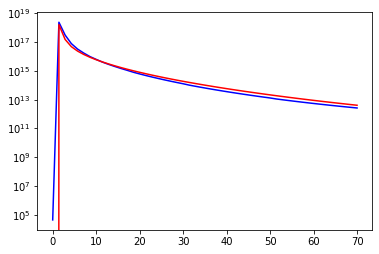

In [80]:
x = np.linspace(0, 70)
nold = result_old.value_at('moments', x)[:, 0]
nnew = result.interpolator.value_at('number_particles', x)
plt.plot(x, nold, 'b')
plt.plot(x, nnew, 'r')
plt.semilogy()

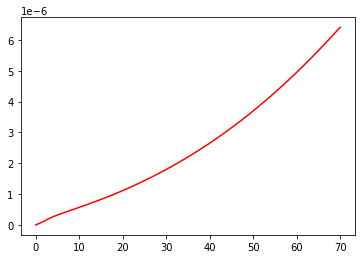

In [81]:
x = np.linspace(0, 70)
vold = result_old.value_at('moments', x)[:, 1]/result_old.value_at('moments', x)[:, 0]
rold = 2*(3/(4*np.pi)*vold)**(1.0/3)
vnew = result.interpolator.value_at('mean_volume', x)
rnew = result.interpolator.value_at('mean_diameter_estimate', x)
rnew = 2*(3/(4*np.pi)*vnew)**(1.0/3)
#plt.plot(x, rold, 'b')
plt.plot(x, rnew, 'r')

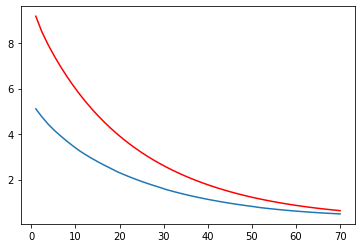

In [82]:
x = np.linspace(1, 70)
plt.plot(x, result_old.value_at('dmdt', x)*3600*1000)
plt.plot(x, result.interpolator.value_at('source_mass', x)*3600*1000, 'r')

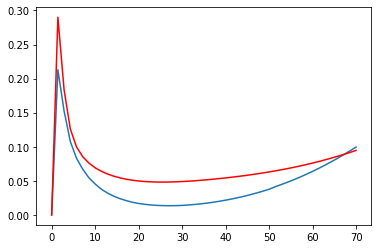

In [73]:
x = np.linspace(0, 70)
plt.plot(x, result_old.value_at('source_mass_particle_deposition', x)*3600*1000)
plt.plot(x, result.interpolator.value_at('source_particle_mass', x)*3600*1000, 'r')

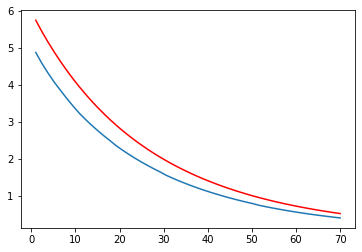

In [74]:
x = np.linspace(1, 70)
plt.plot(x, result_old.value_at('source_mass_ionic_deposition', x)*3600*1000)
plt.plot(x, result.interpolator.value_at('source_ionic_mass', x)*3600*1000, 'r')

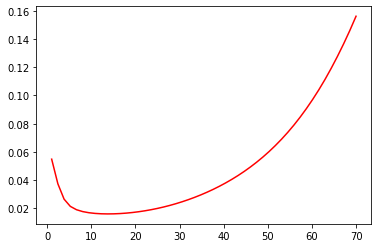

In [75]:
plt.plot(x, result.interpolator.value_at('particle_deposition_proportion', x), 'r')

## result_old.result_keys()